# Infraestructure Manager revenue maximization with GSA

## 0. Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

from benchmarks.railway import Solution, RevenueMaximization
from benchmarks.generator import get_schedule_request, get_revenue_behaviour
from src.entities import GSA

## 1. Generate service requests

As an example, we will use the Spanish south high-speed railway corridor.



In [2]:
south_corridor =   {"MAD": {
                        "CIU": {
                            "COR": {
                                "SEV": {
                                    "CAD": {}
                                       },
                                "PGE": {
                                    "ANT": {
                                        "GRA": {},
                                        "MAL": {}
                                            }
                                        }
                                    }
                                }
                            }
                        }

In [34]:
np.random.seed(seed=28)

schedule = get_schedule_request(south_corridor, 15)
revenue = get_revenue_behaviour(schedule)

schedule, revenue

({1: {'CIU': [1302, 1302],
   'COR': [1364, 1369],
   'PGE': [1481, 1487],
   'ANT': [1575, 1580],
   'GRA': [1628, 1628]},
  2: {'MAD': [606, 606],
   'CIU': [679, 685],
   'COR': [797, 800],
   'SEV': [905, 912],
   'CAD': [995, 995]},
  3: {'MAD': [933, 933],
   'CIU': [1033, 1039],
   'COR': [1091, 1098],
   'SEV': [1136, 1140],
   'CAD': [1170, 1170]},
  4: {'MAD': [963, 963],
   'CIU': [1005, 1008],
   'COR': [1115, 1118],
   'PGE': [1203, 1206],
   'ANT': [1234, 1238],
   'GRA': [1281, 1281]},
  5: {'COR': [537, 537],
   'PGE': [614, 620],
   'ANT': [730, 737],
   'MAL': [762, 762]},
  6: {'PGE': [1284, 1284], 'ANT': [1388, 1392], 'MAL': [1490, 1490]},
  7: {'PGE': [980, 980], 'ANT': [1015, 1021], 'GRA': [1086, 1086]},
  8: {'MAD': [976, 976],
   'CIU': [1045, 1051],
   'COR': [1081, 1087],
   'SEV': [1131, 1137],
   'CAD': [1184, 1184]},
  9: {'ANT': [476, 476], 'MAL': [548, 548]},
  10: {'COR': [489, 489],
   'PGE': [559, 566],
   'ANT': [632, 635],
   'GRA': [700, 700]},
  11

In [20]:
np.random.seed(seed=28)

# Dummy schedule
schedule = {1: {'MAD': [0, 0], 'BAR': [148, 152], 'FIG': [180, 180]},
            2: {'MAD': [8, 8], 'ZAR': [28, 30], 'BAR': [165, 167], 'FIG': [210, 210]},
            3: {'MAD': [30, 30], 'BAR': [180, 182], 'FIG': [225, 225]}}

for service in schedule:
    for station in schedule[service]:
        schedule[service][station] = np.array(schedule[service][station], dtype=np.float64)
        
revenue = get_revenue_behaviour(schedule)

schedule, revenue

({1: {'MAD': array([0., 0.]),
   'BAR': array([148., 152.]),
   'FIG': array([180., 180.])},
  2: {'MAD': array([8., 8.]),
   'ZAR': array([28., 30.]),
   'BAR': array([165., 167.]),
   'FIG': array([210., 210.])},
  3: {'MAD': array([30., 30.]),
   'BAR': array([180., 182.]),
   'FIG': array([225., 225.])}},
 {1: {'canon': 222.75,
   'k': 1.05,
   'dt_max_penalty': 31.18,
   'tt_max_penalty': 28.96},
  2: {'canon': 242.0,
   'k': 1.03,
   'dt_max_penalty': 33.88,
   'tt_max_penalty': 20.97},
  3: {'canon': 198.0,
   'k': 1.18,
   'dt_max_penalty': 27.72,
   'tt_max_penalty': 25.74}})

In [35]:
sm = RevenueMaximization(schedule, revenue, safe_headway=np.float64(10.0))

In [36]:
gsa_algo = GSA(objective_function=sm.get_fitness_gsa,
               is_feasible=sm.feasible_services_times,
               custom_repair=sm.custom_repair,
               r_dim=len(sm.boundaries.real),
               d_dim=0,
               boundaries=sm.boundaries)

In [37]:
import cProfile as profile
import time

pr = profile.Profile()
pr.disable()

#gsa_algo.set_seed(seed=28)

pop_size = 5

start = time.time()
pr.enable()
training_history = gsa_algo.optimize(population_size=pop_size,
                                     iters=50,
                                     chaotic_constant=True,
                                     repair_solution=True,
                                     initial_population=sm.get_initial_population(pop_size))
pr.disable()
print(f"Elapsed time: {time.time() - start}")

pr.dump_stats('profile.pstat')

Initial population: [<src.entities.Solution object at 0x147cc8430>, <src.entities.Solution object at 0x147d77d00>, <src.entities.Solution object at 0x147d8d520>, <src.entities.Solution object at 0x1477daa00>, <src.entities.Solution object at 0x147c2ee20>]
GSA is optimizing  "get_fitness_gsa"
['At iteration 1 the best fitness is 0.0']
['At iteration 2 the best fitness is 1370.0601288214655']
['At iteration 3 the best fitness is 1370.0601288214655']
['At iteration 4 the best fitness is 1370.0601288214655']
['At iteration 5 the best fitness is 1370.0601288214655']
['At iteration 6 the best fitness is 1380.1955061784124']
['At iteration 7 the best fitness is 1403.140009016242']
['At iteration 8 the best fitness is 1403.7505885877597']
['At iteration 9 the best fitness is 1403.7505885877597']
['At iteration 10 the best fitness is 1403.7505885877597']
['At iteration 11 the best fitness is 1403.7505885877597']
['At iteration 12 the best fitness is 1403.7505885877597']
['At iteration 13 the be

In [40]:
# Get last value in column 'Real' of training_history
best_solution_real = training_history.iloc[-1]['Real']
best_solution_real

array([1298.17771701, 1365.71507337, 1486.79040485, 1580.686209  ,
        605.63693881,  688.34077879,  803.73762597,  916.29936268,
        937.79753498, 1047.44444557, 1108.        , 1150.        ,
        968.69947326, 1016.73046759, 1127.7073226 , 1216.        ,
       1248.        ,  536.33354614,  620.53597806,  737.56261273,
       1285.6954609 , 1399.58350323,  985.75633331, 1029.25661965,
        967.59970998, 1046.59628125, 1085.51431836, 1138.9221883 ,
        482.01096027,  498.09905285,  575.41636829,  644.57348041,
        273.29375418,  321.62121697,   96.38953321,  217.07840486,
        278.09881824,  388.62973115,   92.70653924,  153.74917171,
       1242.14509142, 1307.7279819 , 1413.73312525, 1488.        ,
       1594.        , 1374.19764803, 1407.35597265, 1447.20703235,
       1514.44354574])

In [41]:
best_solution = Solution(real=np.array(best_solution_real), discrete=sm.get_heuristic_schedule(np.array(best_solution_real)))

best_solution.real, best_solution.discrete

(array([1298.17771701, 1365.71507337, 1486.79040485, 1580.686209  ,
         605.63693881,  688.34077879,  803.73762597,  916.29936268,
         937.79753498, 1047.44444557, 1108.        , 1150.        ,
         968.69947326, 1016.73046759, 1127.7073226 , 1216.        ,
        1248.        ,  536.33354614,  620.53597806,  737.56261273,
        1285.6954609 , 1399.58350323,  985.75633331, 1029.25661965,
         967.59970998, 1046.59628125, 1085.51431836, 1138.9221883 ,
         482.01096027,  498.09905285,  575.41636829,  644.57348041,
         273.29375418,  321.62121697,   96.38953321,  217.07840486,
         278.09881824,  388.62973115,   92.70653924,  153.74917171,
        1242.14509142, 1307.7279819 , 1413.73312525, 1488.        ,
        1594.        , 1374.19764803, 1407.35597265, 1447.20703235,
        1514.44354574]),
 array([ True,  True, False, False,  True,  True,  True,  True,  True,
        False, False, False, False, False, False]))

In [42]:
sm.is_feasible(best_solution, best_solution.discrete)

True

In [39]:
sm.get_revenue(best_solution)

2791.867192702204

In [40]:
sm.get_revenue(sm.best_solution)

2791.954803464316

In [39]:
sm.is_feasible(sm.best_solution, sm.best_solution.discrete)

True

In [190]:
training_history

,Iteration,Fitness,Accuracy,ExecutionTime,Discrete,Real
0,0,611.669334,0,0.006123,[],"[-7.611309908071238, 152.5516985172423, 8.6721..."
1,1,611.669334,0,0.019382,[],"[6.8799721156115865, 158.8799721156116, 18.0, ..."
2,2,620.509551,0,0.033016,[],"[-4.09540956569017, 149.11275775974016, 10.014..."
3,3,620.509551,0,0.046564,[],"[-5.510352908773724, 146.4896470912263, 4.4237..."
4,4,620.509551,0,0.060252,[],"[-5.510352908773724, 146.4896470912263, 4.4237..."
...,...,...,...,...,...,...
95,95,659.377994,0,0.832858,[],"[-1.6447400241517651, 151.31538166459794, 8.40..."
96,96,659.377994,0,0.838560,[],"[-1.6447400241517651, 151.31538166459794, 8.40..."
97,97,659.377994,0,0.845874,[],"[-1.6447400241517651, 151.31538166459794, 8.40..."
98,98,659.377994,0,0.851507,[],"[-1.6447400241517651, 151.31538166459794, 8.40..."


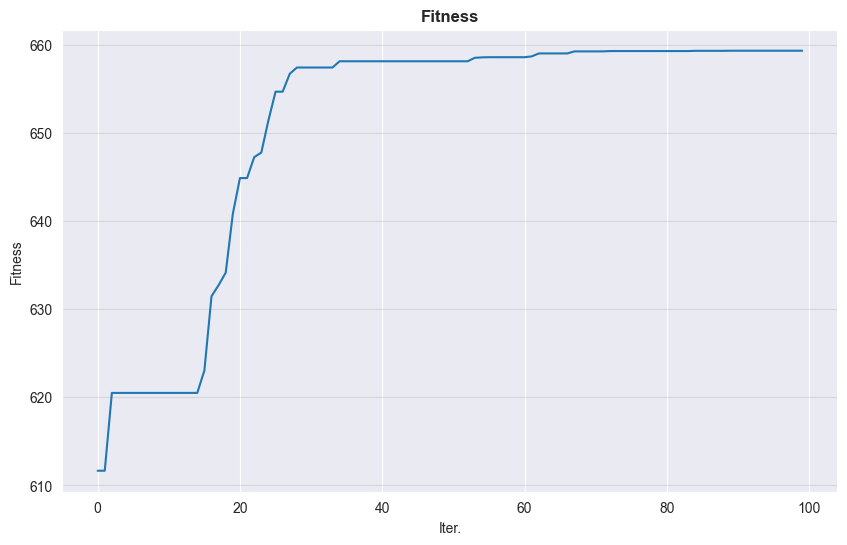

In [191]:
from matplotlib import pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Fitness", fontweight='bold')

# ax.set_ylim(min(global_train_hist["Fitness"]), max(global_train_hist["Fitness"]))
    
sns.lineplot(ax=ax,
             data=training_history,
             x="Iteration",
             y="Fitness",
             legend=True)

ax.grid(axis='y', color='#A9A9A9', alpha=0.3, zorder=1)

ax.set_xlabel("Iter.")
ax.set_ylabel("Fitness")

plt.show()
# fig.savefig(save_path, format='svg', dpi=300, bbox_inches='tight', transparent=True)

In [53]:
!snakeviz profile.pstat

snakeviz web server started on 127.0.0.1:8080; enter Ctrl-C to exit
http://127.0.0.1:8080/snakeviz/%2FUsers%2Fdavid%2FPycharmProjects%2FGSA_M%2Fnotebooks%2Fprofile.pstat
^C

Bye!


In [192]:
sum([revenue[service]['canon'] for service in revenue])

662.75